In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
PATH_OF_TRAIN= '../input/intel-image-classification/seg_train/seg_train'
PATH_OF_TEST= '../input/intel-image-classification/seg_test/seg_test'
PATH_OF_PRED = '../input/intel-image-classification/seg_pred'

In [4]:
data_dir_train = pathlib.Path(PATH_OF_TRAIN)
data_dir_test = pathlib.Path(PATH_OF_TEST)
data_dir_pred = pathlib.Path(PATH_OF_PRED)

In [5]:
imageCount_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of train: ",imageCount_train)
imageCount_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of test: ",imageCount_test)
imageCount_pred = len(list(data_dir_pred.glob('*/*.jpg')))
print("Number of pred: ",imageCount_pred)

Number of train:  14034
Number of test:  3000
Number of pred:  7301


In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))

2022-02-21 19:31:53.839463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 19:31:53.917927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 19:31:53.918732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 19:31:53.921015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier'],
      dtype='<U9')

In [8]:
validation_split = 0.2

In [9]:
DATASET_SIZE = len(list(list_ds))
print("Dataset size: ", DATASET_SIZE)
train_size = int((1-validation_split) * DATASET_SIZE)
print("train size: ", train_size)
train_dataset = list_ds.take(train_size)
validation_dataset = list_ds.skip(train_size)

Dataset size:  14034
train size:  11227


In [11]:
def augment_data(image):
    image = tf.image.resize_with_crop_or_pad(image, 180, 180) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[150, 150, 3]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image

def load_img(image_path):
    img = tf.io.read_file(image_path)
    
    # https://stackoverflow.com/questions/44942729/tensorflowvalueerror-images-contains-no-shape
    img = tf.image.decode_image(img, 3, expand_animations=False)
    
    img = tf.cast(img, tf.float32)
    return img

# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1
    return image

def resize(image,height, width):
    image = tf.image.resize(image, (height, width),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #image = tf.image.resize_with_crop_or_pad(image, height, width)
    return image

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def load_image_with_label(image_path):
    label = get_label(image_path)
    img = load_img(image_path)
    return img, label

def load_image_train(image_file):
    image, label = load_image_with_label(image_file)
    image = augment_data(image)
    image = normalize(image)
    
    return image, label


def load_image_test(image_file):
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = normalize(image)

    return image, label

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = validation_dataset.map(load_image_test)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [14]:
 validation_dataset.batch(BATCH_SIZE)

<BatchDataset shapes: ((None, None, 150, 150, 3), (None, None, 6)), types: (tf.float32, tf.bool)>

In [15]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [16]:
base_model.trainable = False

In [19]:
n_class =len(CLASS_NAMES)
n_class

6

In [20]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(n_class, activation='softmax')

In [21]:
model = tf.keras.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20


2022-02-21 19:38:46.117239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-21 19:38:52.892497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 91s 222ms/step - loss: 0.6744 - accuracy: 0.7393 - val_loss: 0.3445 - val_accuracy: 0.8796
Epoch 2/20
351/351 [==============================] - 42s 113ms/step - loss: 0.5445 - accuracy: 0.8008 - val_loss: 0.3925 - val_accuracy: 0.8518
Epoch 3/20
351/351 [==============================] - 36s 99ms/step - loss: 0.5658 - accuracy: 0.8073 - val_loss: 0.3379 - val_accuracy: 0.8888
Epoch 4/20
351/351 [==============================] - 35s 96ms/step - loss: 0.5458 - accuracy: 0.8134 - val_loss: 0.3677 - val_accuracy: 0.8771
Epoch 5/20
351/351 [==============================] - 34s 93ms/step - loss: 0.5520 - accuracy: 0.8200 - val_loss: 0.4270 - val_accuracy: 0.8717
Epoch 6/20
351/351 [==============================] - 34s 92ms/step - loss: 0.5550 - accuracy: 0.8251 - val_loss: 0.3536 - val_accuracy: 0.8774
Epoch 7/20
351/351 [==============================] - 34s 92ms/step - loss: 0.5382 - accuracy: 0.8242 - val_loss: 0.3403 - val_accuracy: 0.8956
E

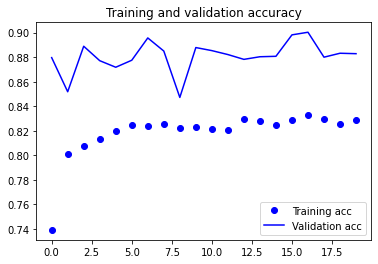

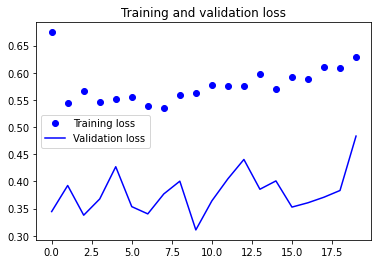

In [25]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()